In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# --- Schritt 1 & 2: Daten laden und vorbereiten ---

# CSV-Datei laden (Pfad ggf. anpassen, wenn die Datei nicht im selben Verzeichnis liegt)
try:
    df = pd.read_csv('ogd115_gest_bilanz.csv')
except FileNotFoundError:
    print("Die Datei 'ogd115_gest_bilanz.csv' wurde nicht gefunden. Bitte überprüfe den Pfad.")
    exit()

# Spalte 'TJ' in numerischen Datentyp umwandeln.
# Fehlerhafte Einträge (z.B. leere Strings) werden zu NaN und dann mit 0 gefüllt.
df['TJ'] = pd.to_numeric(df['TJ'], errors='coerce').fillna(0)

# Sicherstellen, dass 'Jahr' als Integer interpretiert wird
df['Jahr'] = df['Jahr'].astype(int)

# --- Schritt 3: Relevante Datenkategorien identifizieren und filtern & Aggregation ---

# 1. Erneuerbare Energien aus Inlandproduktion
erneuerbare_inland_liste = ["Holzenergie", "Wasserkraft", "Uebrige erneuerbare Energien"]
df_erneuerbare_inland = df[
    (df['Rubrik'] == "Inlandproduktion") &
    (df['Energietraeger'].isin(erneuerbare_inland_liste))
]
# Aggregation pro Jahr
erneuerbare_inland_summe_pro_jahr = df_erneuerbare_inland.groupby('Jahr')['TJ'].sum().reset_index()
erneuerbare_inland_summe_pro_jahr = erneuerbare_inland_summe_pro_jahr.rename(columns={'TJ': 'Erneuerbare_Inland_TJ'})

# 2. Importe fossiler Energieträger
fossile_import_liste = ["Erdölprodukte", "Gas", "Kohle", "Rohöl"]
df_fossile_import = df[
    (df['Rubrik'] == "Import") &
    (df['Energietraeger'].isin(fossile_import_liste))
]
# Aggregation pro Jahr
fossile_import_summe_pro_jahr = df_fossile_import.groupby('Jahr')['TJ'].sum().reset_index()
fossile_import_summe_pro_jahr = fossile_import_summe_pro_jahr.rename(columns={'TJ': 'Fossile_Import_TJ'})

# --- Schritt 4: Daten zusammenführen und Vergleichsmetriken berechnen ---

# Beide aggregierten DataFrames zusammenführen über das Jahr
df_vergleich = pd.merge(erneuerbare_inland_summe_pro_jahr, fossile_import_summe_pro_jahr, on='Jahr', how='outer').fillna(0)

# Sicherstellen, dass die Jahre sortiert sind
df_vergleich = df_vergleich.sort_values(by='Jahr').reset_index(drop=True)

# Berechnung des Verhältnisses (um "NaN" oder "inf" bei Division durch Null zu vermeiden, ersetzen wir 0 im Nenner temporär)
df_vergleich['Verhaeltnis_ErnIn_vs_FossImp'] = df_vergleich['Erneuerbare_Inland_TJ'] / df_vergleich['Fossile_Import_TJ'].replace(0, np.nan)
df_vergleich['Verhaeltnis_ErnIn_vs_FossImp'] = df_vergleich['Verhaeltnis_ErnIn_vs_FossImp'].fillna(0) # NaN füllen, falls Nenner 0 war

# Berechnung des Anteils der Inland-Erneuerbaren an der Summe von Inland-Erneuerbar und Fossil-Import
# Nenner (Summe) darf nicht Null sein
summe_energien = df_vergleich['Erneuerbare_Inland_TJ'] + df_vergleich['Fossile_Import_TJ']
df_vergleich['Anteil_Erneuerbare_Inland_Prozent'] = (df_vergleich['Erneuerbare_Inland_TJ'] / summe_energien.replace(0, np.nan) * 100).fillna(0)


# --- Schritt 5: Informationen präsentieren (Visualisierung) ---

plt.style.use('seaborn-v0_8-whitegrid') # Ein etwas modernerer Plot-Stil


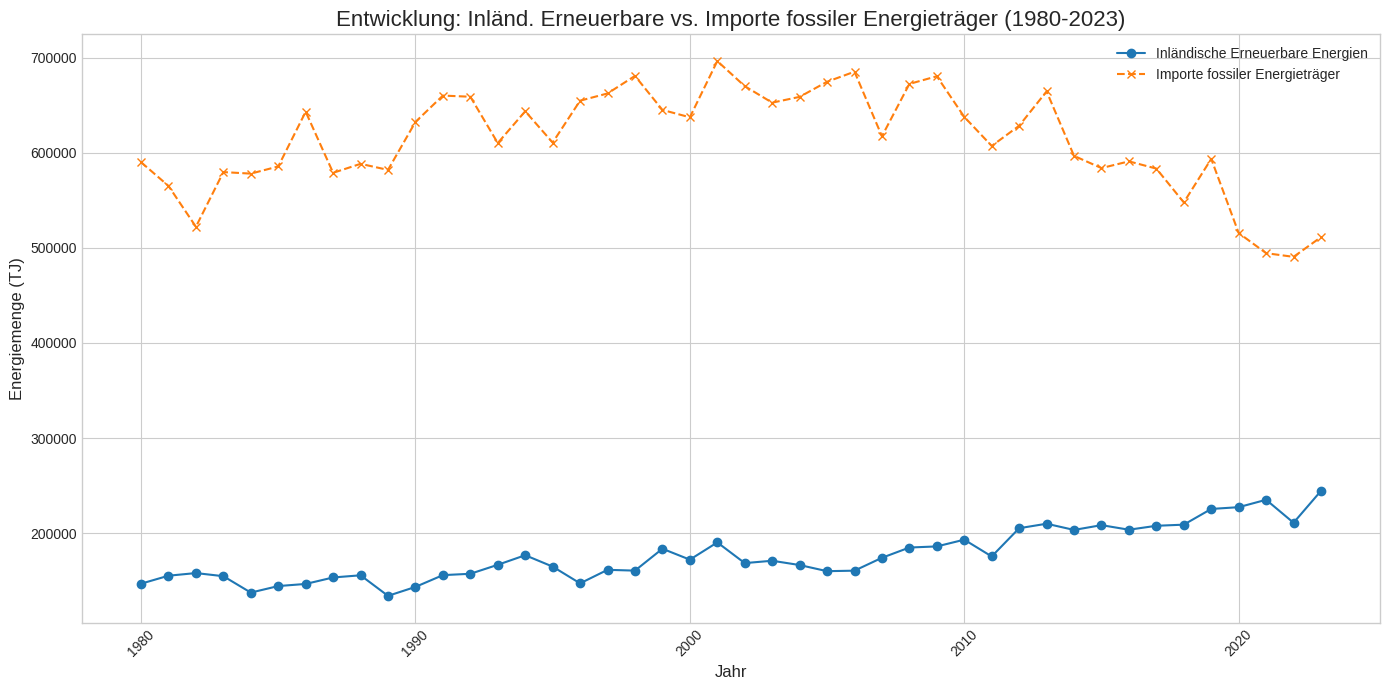

In [ ]:
# Plot 1: Absolute Mengen (TJ) über die Jahre
plt.figure(figsize=(14, 7))
plt.plot(df_vergleich['Jahr'], df_vergleich['Erneuerbare_Inland_TJ'], label='Inländische Erneuerbare Energien', marker='o', linestyle='-')
plt.plot(df_vergleich['Jahr'], df_vergleich['Fossile_Import_TJ'], label='Importe fossiler Energieträger', marker='x', linestyle='--')
plt.title('Entwicklung: Inländ. Erneuerbare vs. Importe fossiler Energieträger (1980-2023)', fontsize=16)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Energiemenge (TJ)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

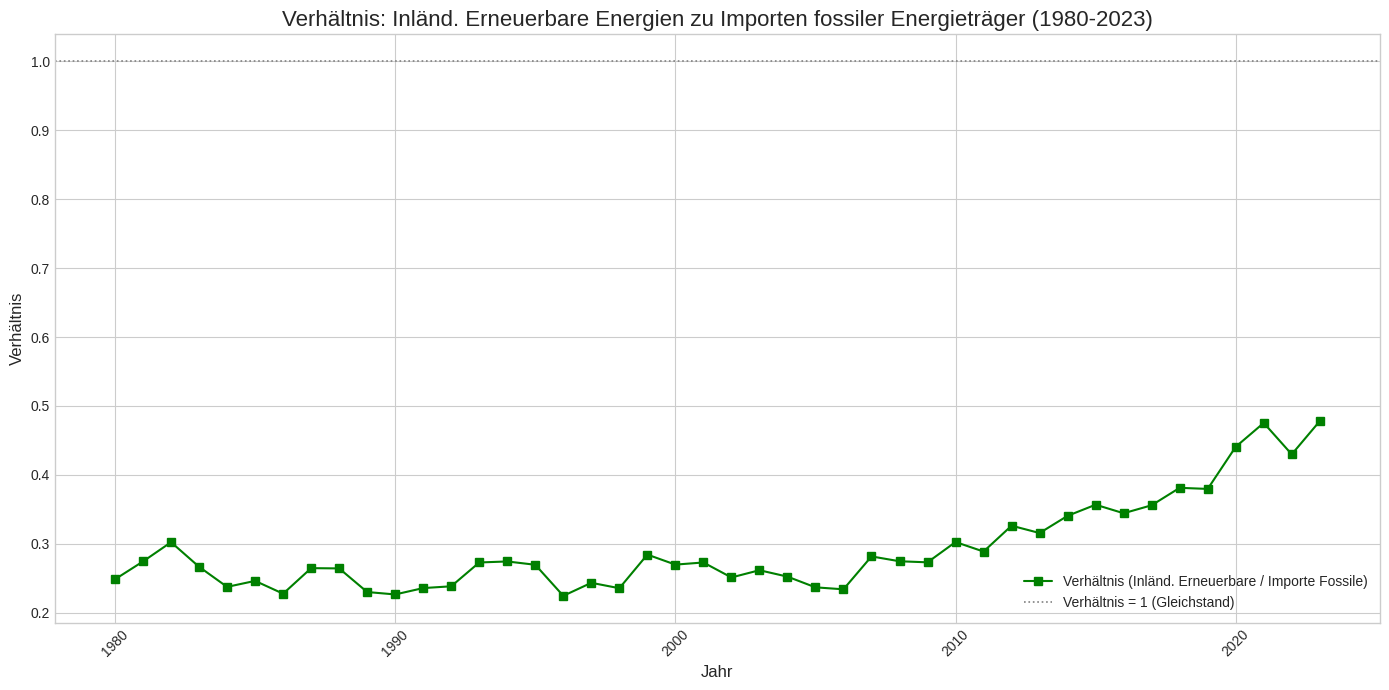

In [ ]:
# Plot 2: Verhältnis Inländische Erneuerbare zu Importe Fossile über die Jahre
plt.figure(figsize=(14, 7))
plt.plot(df_vergleich['Jahr'], df_vergleich['Verhaeltnis_ErnIn_vs_FossImp'], label='Verhältnis (Inländ. Erneuerbare / Importe Fossile)', marker='s', color='green')
plt.title('Verhältnis: Inländ. Erneuerbare Energien zu Importen fossiler Energieträger (1980-2023)', fontsize=16)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Verhältnis', fontsize=12)
plt.axhline(1, color='grey', linestyle=':', linewidth=1.2, label='Verhältnis = 1 (Gleichstand)') # Referenzlinie
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


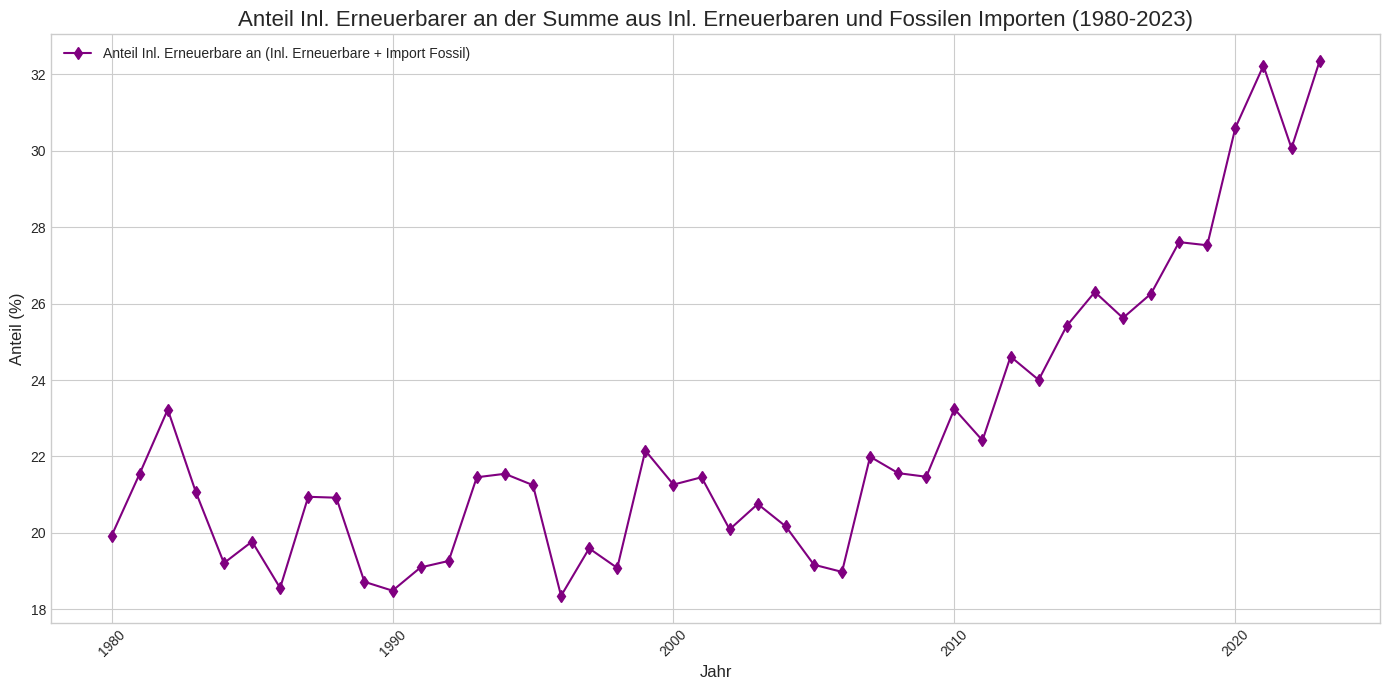

In [ ]:
# Plot 3: Anteil der inländischen Erneuerbaren an der Summe (Inland Erneuerbar + Import Fossil)
plt.figure(figsize=(14, 7))
plt.plot(df_vergleich['Jahr'], df_vergleich['Anteil_Erneuerbare_Inland_Prozent'], label='Anteil Inl. Erneuerbare an (Inl. Erneuerbare + Import Fossil)', marker='d', color='purple')
plt.title('Anteil Inl. Erneuerbarer an der Summe aus Inl. Erneuerbaren und Fossilen Importen (1980-2023)', fontsize=16)
plt.xlabel('Jahr', fontsize=12)
plt.ylabel('Anteil (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.ticker as mtick # Für Prozentformatierung

In [ ]:
# --- Schritt 3: Relevante Datenkategorien identifizieren und filtern & Aggregation ---
erneuerbare_inland_liste = ["Holzenergie", "Wasserkraft", "Uebrige erneuerbare Energien"]
df_erneuerbare_inland = df[
    (df['Rubrik'] == "Inlandproduktion") &
    (df['Energietraeger'].isin(erneuerbare_inland_liste))
]
erneuerbare_inland_summe_pro_jahr = df_erneuerbare_inland.groupby('Jahr')['TJ'].sum().reset_index()
erneuerbare_inland_summe_pro_jahr = erneuerbare_inland_summe_pro_jahr.rename(columns={'TJ': 'Erneuerbare_Inland_TJ'})

fossile_import_liste = ["Erdölprodukte", "Gas", "Kohle", "Rohöl"]
df_fossile_import = df[
    (df['Rubrik'] == "Import") &
    (df['Energietraeger'].isin(fossile_import_liste))
]
fossile_import_summe_pro_jahr = df_fossile_import.groupby('Jahr')['TJ'].sum().reset_index()
fossile_import_summe_pro_jahr = fossile_import_summe_pro_jahr.rename(columns={'TJ': 'Fossile_Import_TJ'})


# --- Schritt 4: Daten zusammenführen und Vergleichsmetriken berechnen ---
df_vergleich = pd.merge(erneuerbare_inland_summe_pro_jahr, fossile_import_summe_pro_jahr, on='Jahr', how='outer').fillna(0)
df_vergleich = df_vergleich.sort_values(by='Jahr').reset_index(drop=True)

# Differenz berechnen
df_vergleich['Differenz_ErnIn_minus_FossImp'] = df_vergleich['Erneuerbare_Inland_TJ'] - df_vergleich['Fossile_Import_TJ']

# Für 100% Stacked Area Chart: Anteile berechnen
summe_energien = df_vergleich['Erneuerbare_Inland_TJ'] + df_vergleich['Fossile_Import_TJ']
# Um Division durch Null zu vermeiden, wenn beide Energieträger 0 sind
df_vergleich['Anteil_Erneuerbare_Inland_Prozent_Stack'] = np.where(summe_energien == 0, 0, (df_vergleich['Erneuerbare_Inland_TJ'] / summe_energien) * 100)
df_vergleich['Anteil_Fossile_Import_Prozent_Stack'] = np.where(summe_energien == 0, 0, (df_vergleich['Fossile_Import_TJ'] / summe_energien) * 100)


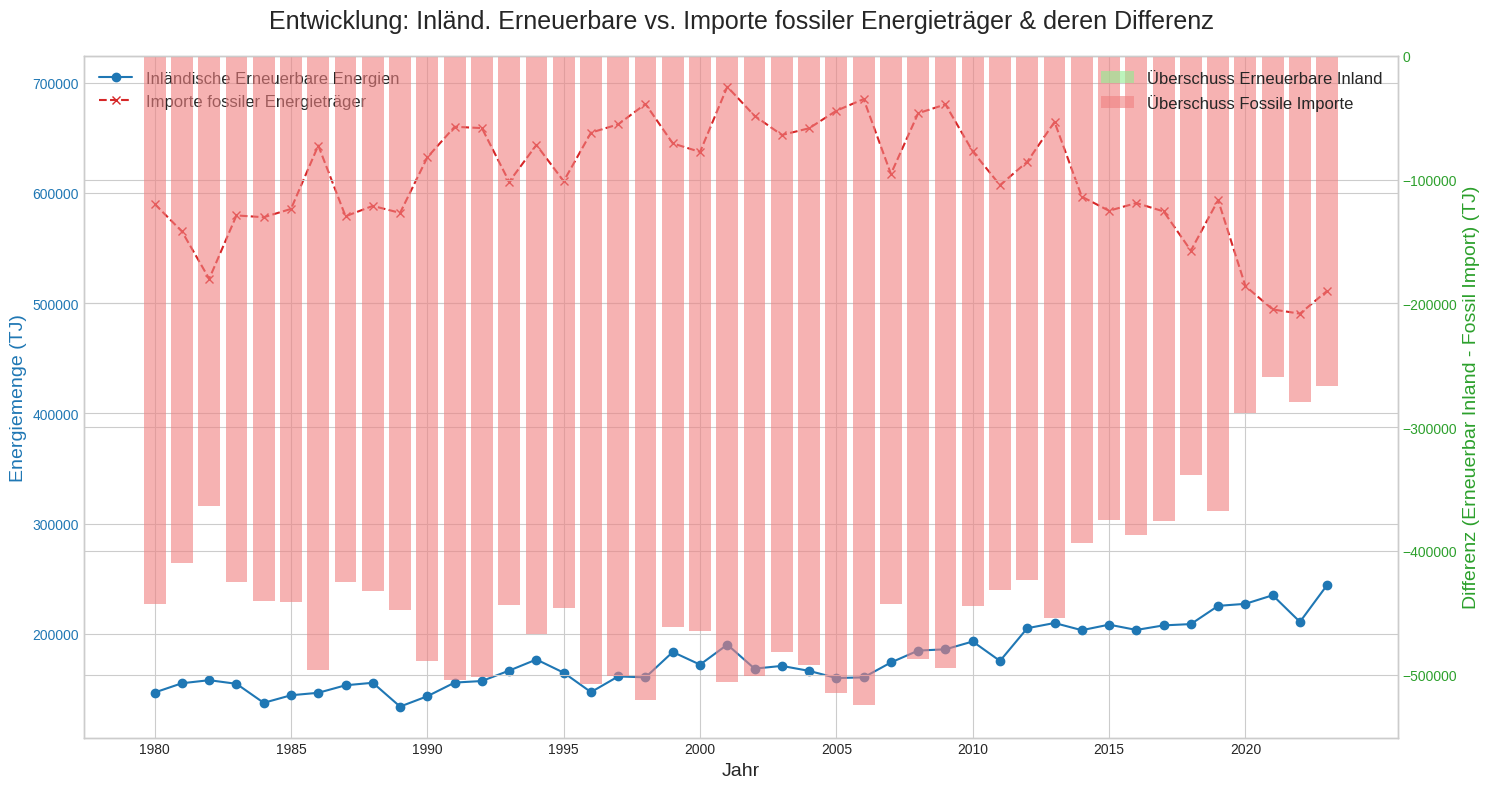

In [ ]:
# Plot 1: Absolute Mengen (TJ) mit Differenz als Balken (Kombinationsdiagramm-Ansatz)
fig, ax1 = plt.subplots(figsize=(15, 8))

# Linien für die Mengen
color = 'tab:blue'
ax1.set_xlabel('Jahr', fontsize=14)
ax1.set_ylabel('Energiemenge (TJ)', color=color, fontsize=14)
ax1.plot(df_vergleich['Jahr'], df_vergleich['Erneuerbare_Inland_TJ'], color=color, linestyle='-', marker='o', label='Inländische Erneuerbare Energien')
ax1.plot(df_vergleich['Jahr'], df_vergleich['Fossile_Import_TJ'], color='tab:red', linestyle='--', marker='x', label='Importe fossiler Energieträger')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left', fontsize=12)

# Zweite Y-Achse für die Differenz-Balken
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Differenz (Erneuerbar Inland - Fossil Import) (TJ)', color=color, fontsize=14)
# Positive und negative Differenzen unterschiedlich färben
positive_diff = df_vergleich['Differenz_ErnIn_minus_FossImp'].copy()
positive_diff[positive_diff < 0] = 0
negative_diff = df_vergleich['Differenz_ErnIn_minus_FossImp'].copy()
negative_diff[negative_diff > 0] = 0

ax2.bar(df_vergleich['Jahr'], positive_diff, color='lightgreen', alpha=0.6, label='Überschuss Erneuerbare Inland')
ax2.bar(df_vergleich['Jahr'], negative_diff, color='lightcoral', alpha=0.6, label='Überschuss Fossile Importe')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right', fontsize=12)

plt.title('Entwicklung: Inländ. Erneuerbare vs. Importe fossiler Energieträger & deren Differenz', fontsize=18, pad=20)
fig.tight_layout() # ansonsten wird die rechte y-Achse manchmal abgeschnitten
plt.xticks(df_vergleich['Jahr'][::5]) # Zeige jedes 5. Jahr für bessere Lesbarkeit
plt.show()


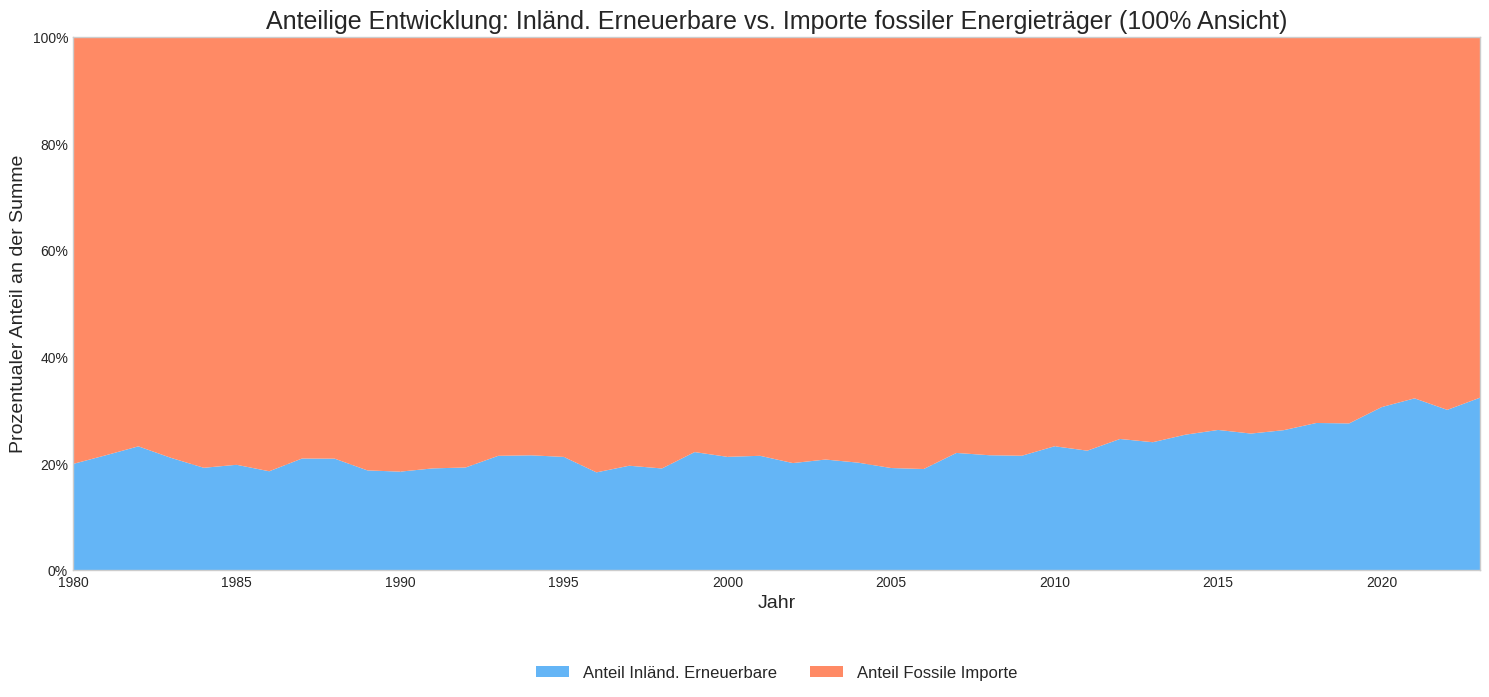

In [ ]:
# Plot 2: 100% Gestapeltes Flächendiagramm
plt.figure(figsize=(15, 8))
plt.stackplot(df_vergleich['Jahr'],
              df_vergleich['Anteil_Erneuerbare_Inland_Prozent_Stack'],
              df_vergleich['Anteil_Fossile_Import_Prozent_Stack'],
              labels=['Anteil Inländ. Erneuerbare', 'Anteil Fossile Importe'],
              colors=['#64B5F6', '#FF8A65']) # Helle Blau- und Orangetöne

plt.title('Anteilige Entwicklung: Inländ. Erneuerbare vs. Importe fossiler Energieträger (100% Ansicht)', fontsize=18)
plt.xlabel('Jahr', fontsize=14)
plt.ylabel('Prozentualer Anteil an der Summe', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2, fontsize=12)
plt.margins(0,0) # Keine Ränder
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter()) # Y-Achse als Prozent formatieren
plt.xticks(df_vergleich['Jahr'][::5]) # Zeige jedes 5. Jahr
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Platz für Legende unter dem Plot lassen
plt.show()


In [ ]:
import plotly.express as px
import plotly.graph_objects as go # Für komplexere Layouts oder spezifische Anpassungen

In [ ]:
# --- Schritt 3: Relevante Datenkategorien identifizieren und filtern & Aggregation ---

# Listen der Energieträger
erneuerbare_inland_traeger = ["Holzenergie", "Wasserkraft", "Uebrige erneuerbare Energien"]
fossile_import_traeger = ["Erdölprodukte", "Gas", "Kohle", "Rohöl"]

# Farbcodierung definieren
farben_erneuerbar_inland = {
    "Holzenergie": "#1f77b4",  # Blau
    "Wasserkraft": "#aec7e8",  # Hellblau
    "Uebrige erneuerbare Energien": "#72bcd4" # Türkis
}
farben_fossil_import = {
    "Erdölprodukte": "#ff7f0e",  # Orange
    "Gas": "#ffbb78",           # Helles Orange
    "Kohle": "#d62728",         # Rot
    "Rohöl": "#ff9896"          # Helles Rot
}
# Kombinierte Farbpalette für konsistente Verwendung
color_discrete_map_combined = {**farben_erneuerbar_inland, **farben_fossil_import}

# 1. Daten für Erneuerbare Inland (detailliert nach Träger und aggregiert)
df_erneuerbare_inland_detail = df[
    (df['Rubrik'] == "Inlandproduktion") &
    (df['Energietraeger'].isin(erneuerbare_inland_traeger))
].groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
df_erneuerbare_inland_detail['Kategorie'] = 'Inländische Erneuerbare'

erneuerbare_inland_summe_pro_jahr = df_erneuerbare_inland_detail.groupby('Jahr')['TJ'].sum().reset_index()
erneuerbare_inland_summe_pro_jahr = erneuerbare_inland_summe_pro_jahr.rename(columns={'TJ': 'Erneuerbare_Inland_TJ'})

# 2. Daten für Fossile Importe (detailliert nach Träger und aggregiert)
df_fossile_import_detail = df[
    (df['Rubrik'] == "Import") &
    (df['Energietraeger'].isin(fossile_import_traeger))
].groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
df_fossile_import_detail['Kategorie'] = 'Importe fossiler Energieträger'

fossile_import_summe_pro_jahr = df_fossile_import_detail.groupby('Jahr')['TJ'].sum().reset_index()
fossile_import_summe_pro_jahr = fossile_import_summe_pro_jahr.rename(columns={'TJ': 'Fossile_Import_TJ'})

# --- Schritt 4: Daten zusammenführen für Gesamtvergleich und Verhältnis ---
df_vergleich_gesamt = pd.merge(erneuerbare_inland_summe_pro_jahr, fossile_import_summe_pro_jahr, on='Jahr', how='outer').fillna(0)
df_vergleich_gesamt = df_vergleich_gesamt.sort_values(by='Jahr').reset_index(drop=True)

df_vergleich_gesamt['Verhaeltnis_ErnIn_vs_FossImp'] = df_vergleich_gesamt['Erneuerbare_Inland_TJ'] / df_vergleich_gesamt['Fossile_Import_TJ'].replace(0, np.nan)
df_vergleich_gesamt['Verhaeltnis_ErnIn_vs_FossImp'] = df_vergleich_gesamt['Verhaeltnis_ErnIn_vs_FossImp'].fillna(0)

summe_energien_gesamt = df_vergleich_gesamt['Erneuerbare_Inland_TJ'] + df_vergleich_gesamt['Fossile_Import_TJ']
df_vergleich_gesamt['Anteil_Erneuerbare_Inland_Prozent'] = (df_vergleich_gesamt['Erneuerbare_Inland_TJ'] / summe_energien_gesamt.replace(0, np.nan) * 100).fillna(0)
df_vergleich_gesamt['Anteil_Fossile_Import_Prozent'] = (df_vergleich_gesamt['Fossile_Import_TJ'] / summe_energien_gesamt.replace(0, np.nan) * 100).fillna(0)


In [ ]:
# Plot 1: Gestapeltes Flächendiagramm der absoluten Energiemengen (TJ)
# Kombiniere die detaillierten Daten für diesen Plot
df_detail_combined = pd.concat([df_erneuerbare_inland_detail, df_fossile_import_detail])

fig1 = px.area(df_detail_combined,
               x="Jahr",
               y="TJ",
               color="Energietraeger",
               line_group="Kategorie", # Wichtig, um die Stapelung pro Hauptkategorie zu steuern
               color_discrete_map=color_discrete_map_combined,
               title="Entwicklung der Energiemengen: Inländische Erneuerbare vs. Importe fossiler Energieträger (TJ)",
               labels={"TJ": "Energiemenge (TJ)", "Jahr": "Jahr", "Energietraeger": "Energieträger"},
               category_orders={"Energietraeger": erneuerbare_inland_traeger + fossile_import_traeger} # Reihenfolge in Legende
              )
fig1.update_layout(title_x=0.5, legend_title_text='Energieträger & Kategorie', hovermode="x unified")
fig1.show()


In [ ]:
# Plot 2: 100% Gestapeltes Flächendiagramm für die Anteile der Hauptkategorien
# Wir nutzen df_vergleich_gesamt, das die summierten Anteile enthält
df_anteile_melted = df_vergleich_gesamt.melt(id_vars=['Jahr'],
                                            value_vars=['Anteil_Erneuerbare_Inland_Prozent', 'Anteil_Fossile_Import_Prozent'],
                                            var_name='Kategorie_Anteil', value_name='Prozentualer_Anteil')

# Umbenennung für schönere Legende
df_anteile_melted['Kategorie_Anteil'] = df_anteile_melted['Kategorie_Anteil'].replace({
    'Anteil_Erneuerbare_Inland_Prozent': 'Anteil Inländ. Erneuerbare',
    'Anteil_Fossile_Import_Prozent': 'Anteil Fossile Importe'
})

fig2 = px.area(df_anteile_melted,
               x="Jahr",
               y="Prozentualer_Anteil",
               color="Kategorie_Anteil",
               title="Anteilige Entwicklung: Inländ. Erneuerbare vs. Importe fossiler Energieträger (100% Ansicht)",
               labels={"Prozentualer_Anteil": "Prozentualer Anteil (%)", "Jahr": "Jahr", "Kategorie_Anteil": "Kategorie"},
               color_discrete_map={ # Farben für die Hauptkategorien
                   'Anteil Inländ. Erneuerbare': '#1f77b4', # Hauptblau
                   'Anteil Fossile Importe': '#ff7f0e'  # Hauptorange
               },
               groupnorm='percent' # Wichtig für 100% Stapelung
              )
fig2.update_layout(title_x=0.5, legend_title_text='Energiekategorie', hovermode="x unified")
fig2.update_yaxes(ticksuffix="%")
fig2.show()


In [ ]:
# Plot 3: Interaktives Liniendiagramm für das Verhältnis
fig3 = px.line(df_vergleich_gesamt,
                x="Jahr",
                y="Verhaeltnis_ErnIn_vs_FossImp",
                title="Verhältnis: Inländ. Erneuerbare Energien zu Importen fossiler Energieträger",
                labels={"Verhaeltnis_ErnIn_vs_FossImp": "Verhältnis (Inl. Erneuerbare / Fossile Importe)", "Jahr": "Jahr"},
                markers=True)
fig3.add_hline(y=1, line_dash="dash", line_color="grey", annotation_text="Gleichstand (Verhältnis=1)", annotation_position="bottom right")
fig3.update_layout(title_x=0.5, hovermode="x unified")
fig3.show()


In [ ]:
# --- Schritt 3: Energieträgerlisten und Farbcodierungen ---
erneuerbare_inland_basis = ["Holzenergie", "Wasserkraft", "Uebrige erneuerbare Energien"]
muell_industrieabfaelle = ["Müll und Industrieabfälle"]
erneuerbare_inland_mit_muell = erneuerbare_inland_basis + muell_industrieabfaelle

fossile_import_traeger = ["Erdölprodukte", "Gas", "Kohle", "Rohöl"]

# Farbcodierung (erweitert)
farben_erneuerbar_inland = {
    "Holzenergie": "#1f77b4",
    "Wasserkraft": "#aec7e8",
    "Uebrige erneuerbare Energien": "#72bcd4",
    "Müll und Industrieabfälle": "#2ca02c"  # Grün für Müll, wenn als erneuerbar gezählt
}
farben_fossil_import = {
    "Erdölprodukte": "#ff7f0e",
    "Gas": "#ffbb78",
    "Kohle": "#d62728",
    "Rohöl": "#ff9896"
}
color_discrete_map_szenario1 = {**{k: v for k, v in farben_erneuerbar_inland.items() if k != "Müll und Industrieabfälle"}, **farben_fossil_import}
color_discrete_map_szenario2 = {**farben_erneuerbar_inland, **farben_fossil_import}

# --- Hilfsfunktion zur Datenaggregation und -aufbereitung ---
def prepare_scenario_data(df_input, erneuerbare_liste, fossile_liste, include_muell_in_erneuerbar_label=False):
    # Erneuerbare Inland (detailliert)
    df_ern_inland_detail = df_input[
        (df_input['Rubrik'] == "Inlandproduktion") &
        (df_input['Energietraeger'].isin(erneuerbare_liste))
    ].groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
    df_ern_inland_detail['Kategorie_Typ'] = 'Inländische Erneuerbare' + (' inkl. Müll' if include_muell_in_erneuerbar_label and "Müll und Industrieabfälle" in erneuerbare_liste else '')

    # Erneuerbare Inland (summiert)
    ern_inland_summe = df_ern_inland_detail.groupby('Jahr')['TJ'].sum().reset_index()
    ern_inland_summe = ern_inland_summe.rename(columns={'TJ': 'Erneuerbare_Inland_TJ'})

    # Fossile Importe (detailliert)
    df_foss_import_detail = df_input[
        (df_input['Rubrik'] == "Import") &
        (df_input['Energietraeger'].isin(fossile_liste))
    ].groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
    df_foss_import_detail['Kategorie_Typ'] = 'Importe fossiler Energieträger'

    # Fossile Importe (summiert)
    foss_import_summe = df_foss_import_detail.groupby('Jahr')['TJ'].sum().reset_index()
    foss_import_summe = foss_import_summe.rename(columns={'TJ': 'Fossile_Import_TJ'})

    # Kombinierte Detaildaten für gestapelte Plots
    df_detail_kombiniert = pd.concat([df_ern_inland_detail, df_foss_import_detail])

    # Gesamtvergleichsdaten
    df_vergleich = pd.merge(ern_inland_summe, foss_import_summe, on='Jahr', how='outer').fillna(0)
    df_vergleich = df_vergleich.sort_values(by='Jahr').reset_index(drop=True)

    df_vergleich['Verhaeltnis_ErnIn_vs_FossImp'] = df_vergleich['Erneuerbare_Inland_TJ'] / df_vergleich['Fossile_Import_TJ'].replace(0, np.nan)
    df_vergleich['Verhaeltnis_ErnIn_vs_FossImp'] = df_vergleich['Verhaeltnis_ErnIn_vs_FossImp'].fillna(0)

    summe_energien = df_vergleich['Erneuerbare_Inland_TJ'] + df_vergleich['Fossile_Import_TJ']
    df_vergleich['Anteil_Erneuerbare_Inland_Prozent'] = (df_vergleich['Erneuerbare_Inland_TJ'] / summe_energien.replace(0, np.nan) * 100).fillna(0)
    df_vergleich['Anteil_Fossile_Import_Prozent'] = (df_vergleich['Fossile_Import_TJ'] / summe_energien.replace(0, np.nan) * 100).fillna(0)

    return df_detail_kombiniert, df_vergleich


In [ ]:
# --- Szenario 1: Ohne Müll bei Erneuerbaren ---
print("--- Analyse Szenario 1: Erneuerbare Energien (Basisdefinition) ---")
df_detail_s1, df_vergleich_s1 = prepare_scenario_data(df, erneuerbare_inland_basis, fossile_import_traeger)

# Plot 1a: Absolute Mengen (TJ) - Szenario 1
fig1a = px.area(df_detail_s1, x="Jahr", y="TJ", color="Energietraeger", line_group="Kategorie_Typ",
                color_discrete_map=color_discrete_map_szenario1,
                title="Szenario 1: Entwicklung der Energiemengen (TJ) - Erneuerbare (Basis) vs. Fossile Importe",
                labels={"TJ": "Energiemenge (TJ)", "Energietraeger": "Energieträger"},
                category_orders={"Energietraeger": erneuerbare_inland_basis + fossile_import_traeger})
fig1a.update_layout(title_x=0.5, legend_title_text='Energieträger', hovermode="x unified")
fig1a.show()

# Plot 2a: 100% Gestapeltes Flächendiagramm - Szenario 1
df_anteile_s1_melted = df_vergleich_s1.melt(id_vars=['Jahr'],
                                          value_vars=['Anteil_Erneuerbare_Inland_Prozent', 'Anteil_Fossile_Import_Prozent'],
                                          var_name='Kategorie_Anteil', value_name='Prozentualer_Anteil')
df_anteile_s1_melted['Kategorie_Anteil'] = df_anteile_s1_melted['Kategorie_Anteil'].replace({
    'Anteil_Erneuerbare_Inland_Prozent': 'Anteil Inländ. Erneuerbare (Basis)',
    'Anteil_Fossile_Import_Prozent': 'Anteil Fossile Importe'
})
fig2a = px.area(df_anteile_s1_melted, x="Jahr", y="Prozentualer_Anteil", color="Kategorie_Anteil",
                title="Szenario 1: Anteilige Entwicklung - Erneuerbare (Basis) vs. Fossile Importe (100% Ansicht)",
                labels={"Prozentualer_Anteil": "Prozentualer Anteil (%)", "Kategorie_Anteil": "Kategorie"},
                color_discrete_map={'Anteil Inländ. Erneuerbare (Basis)': '#1f77b4', 'Anteil Fossile Importe': '#ff7f0e'},
                groupnorm='percent')
fig2a.update_layout(title_x=0.5, legend_title_text='Energiekategorie', hovermode="x unified")
fig2a.update_yaxes(ticksuffix="%")
fig2a.show()

# Plot 3a: Verhältnis - Szenario 1
fig3a = px.line(df_vergleich_s1, x="Jahr", y="Verhaeltnis_ErnIn_vs_FossImp",
                 title="Szenario 1: Verhältnis Inländ. Erneuerbare (Basis) zu Importen fossiler Energieträger",
                 labels={"Verhaeltnis_ErnIn_vs_FossImp": "Verhältnis", "Jahr": "Jahr"}, markers=True)
fig3a.add_hline(y=1, line_dash="dash", line_color="grey", annotation_text="Gleichstand (Verhältnis=1)")
fig3a.update_layout(title_x=0.5, hovermode="x unified")
fig3a.show()


--- Analyse Szenario 1: Erneuerbare Energien (Basisdefinition) ---


In [ ]:
# --- Szenario 2: Mit Müll bei Erneuerbaren ---
print("\n--- Analyse Szenario 2: Erneuerbare Energien inkl. Müll und Industrieabfälle ---")
print("HINWEIS: Die Zurechnung der gesamten Menge 'Müll und Industrieabfälle' zu erneuerbaren Energien ist eine Vereinfachung. Nur der biogene Anteil ist tatsächlich erneuerbar.")
df_detail_s2, df_vergleich_s2 = prepare_scenario_data(df, erneuerbare_inland_mit_muell, fossile_import_traeger, include_muell_in_erneuerbar_label=True)

# Plot 1b: Absolute Mengen (TJ) - Szenario 2
fig1b = px.area(df_detail_s2, x="Jahr", y="TJ", color="Energietraeger", line_group="Kategorie_Typ",
                color_discrete_map=color_discrete_map_szenario2,
                title="Szenario 2: Entwicklung der Energiemengen (TJ) - Erneuerbare (inkl. Müll) vs. Fossile Importe",
                labels={"TJ": "Energiemenge (TJ)", "Energietraeger": "Energieträger"},
                category_orders={"Energietraeger": erneuerbare_inland_mit_muell + fossile_import_traeger})
fig1b.update_layout(title_x=0.5, legend_title_text='Energieträger', hovermode="x unified")
fig1b.show()

# Plot 2b: 100% Gestapeltes Flächendiagramm - Szenario 2
df_anteile_s2_melted = df_vergleich_s2.melt(id_vars=['Jahr'],
                                          value_vars=['Anteil_Erneuerbare_Inland_Prozent', 'Anteil_Fossile_Import_Prozent'],
                                          var_name='Kategorie_Anteil', value_name='Prozentualer_Anteil')
df_anteile_s2_melted['Kategorie_Anteil'] = df_anteile_s2_melted['Kategorie_Anteil'].replace({
    'Anteil_Erneuerbare_Inland_Prozent': 'Anteil Inländ. Erneuerbare (inkl. Müll)',
    'Anteil_Fossile_Import_Prozent': 'Anteil Fossile Importe'
})
fig2b = px.area(df_anteile_s2_melted, x="Jahr", y="Prozentualer_Anteil", color="Kategorie_Anteil",
                title="Szenario 2: Anteilige Entwicklung - Erneuerbare (inkl. Müll) vs. Fossile Importe (100% Ansicht)",
                labels={"Prozentualer_Anteil": "Prozentualer Anteil (%)", "Kategorie_Anteil": "Kategorie"},
                color_discrete_map={'Anteil Inländ. Erneuerbare (inkl. Müll)': '#2ca02c', 'Anteil Fossile Importe': '#ff7f0e'}, # Grün für die Müll-Variante
                groupnorm='percent')
fig2b.update_layout(title_x=0.5, legend_title_text='Energiekategorie', hovermode="x unified")
fig2b.update_yaxes(ticksuffix="%")
fig2b.show()

# Plot 3b: Verhältnis - Szenario 2
fig3b = px.line(df_vergleich_s2, x="Jahr", y="Verhaeltnis_ErnIn_vs_FossImp",
                 title="Szenario 2: Verhältnis Inländ. Erneuerbare (inkl. Müll) zu Importen fossiler Energieträger",
                 labels={"Verhaeltnis_ErnIn_vs_FossImp": "Verhältnis", "Jahr": "Jahr"}, markers=True)
fig3b.add_hline(y=1, line_dash="dash", line_color="grey", annotation_text="Gleichstand (Verhältnis=1)")
fig3b.update_layout(title_x=0.5, hovermode="x unified")
fig3b.show()



--- Analyse Szenario 2: Erneuerbare Energien inkl. Müll und Industrieabfälle ---
HINWEIS: Die Zurechnung der gesamten Menge 'Müll und Industrieabfälle' zu erneuerbaren Energien ist eine Vereinfachung. Nur der biogene Anteil ist tatsächlich erneuerbar.


In [ ]:
from plotly.subplots import make_subplots # Wichtig für das Dashboard-Layout

In [ ]:
# --- Schritt 1 & 2: Daten laden und vorbereiten ---
try:
    df = pd.read_csv('ogd115_gest_bilanz.csv')
except FileNotFoundError:
    print("Die Datei 'ogd115_gest_bilanz.csv' wurde nicht gefunden. Bitte überprüfe den Pfad.")
    exit()

df['TJ'] = pd.to_numeric(df['TJ'], errors='coerce').fillna(0)
df['Jahr'] = df['Jahr'].astype(int)
df = df[df['Jahr'] >= 1980] # Sicherstellen, dass wir bei 1980 starten

# --- Schritt 3: Energieträgerlisten und Farbcodierungen ---
erneuerbare_inland_basis = ["Holzenergie", "Wasserkraft", "Uebrige erneuerbare Energien"]
muell_industrieabfaelle_name = "Müll und Industrieabfälle" # Als Variable für leichtere Handhabung
erneuerbare_inland_mit_muell = erneuerbare_inland_basis + [muell_industrieabfaelle_name]

fossile_import_traeger = ["Erdölprodukte", "Gas", "Kohle", "Rohöl"]

# Farbcodierung
farben_erneuerbar_inland_dict = {
    "Holzenergie": "cornflowerblue",
    "Wasserkraft": "royalblue",
    "Uebrige erneuerbare Energien": "lightskyblue",
    muell_industrieabfaelle_name: "mediumseagreen" # Grün für Müll
}
farben_fossil_import_dict = {
    "Erdölprodukte": "salmon",
    "Gas": "orangered",
    "Kohle": "firebrick",
    "Rohöl": "lightcoral"
}
# Für aggregierte Kategorien
farbe_erneuerbar_aggregiert = "darkblue"
farbe_fossil_aggregiert = "darkred"
farbe_erneuerbar_mit_muell_aggregiert = "darkgreen"


# --- Hilfsfunktion zur Datenaggregation ---
def get_aggregated_data(df_input, relevant_traeger, rubrik, neue_spalten_name):
    df_filtered = df_input[
        (df_input['Rubrik'] == rubrik) &
        (df_input['Energietraeger'].isin(relevant_traeger))
    ]
    df_agg = df_filtered.groupby('Jahr')['TJ'].sum().reset_index()
    df_agg = df_agg.rename(columns={'TJ': neue_spalten_name})
    return df_agg

# --- Daten für beide Szenarien vorbereiten ---

# Szenario 1: Erneuerbare Basis
df_ern_basis_sum = get_aggregated_data(df, erneuerbare_inland_basis, "Inlandproduktion", "Erneuerbare_Basis_TJ")
df_foss_import_sum = get_aggregated_data(df, fossile_import_traeger, "Import", "Fossile_Import_TJ")
df_s1 = pd.merge(df_ern_basis_sum, df_foss_import_sum, on="Jahr", how="outer").fillna(0).sort_values("Jahr")
summe_s1 = df_s1["Erneuerbare_Basis_TJ"] + df_s1["Fossile_Import_TJ"]
df_s1["Anteil_Erneuerbare_Basis_%"] = np.where(summe_s1 == 0, 0, (df_s1["Erneuerbare_Basis_TJ"] / summe_s1) * 100)
df_s1["Anteil_Fossile_Import_%"] = np.where(summe_s1 == 0, 0, (df_s1["Fossile_Import_TJ"] / summe_s1) * 100)

# Szenario 2: Erneuerbare inkl. Müll
df_ern_mit_muell_sum = get_aggregated_data(df, erneuerbare_inland_mit_muell, "Inlandproduktion", "Erneuerbare_Mit_Muell_TJ")
# df_foss_import_sum bleibt gleich
df_s2 = pd.merge(df_ern_mit_muell_sum, df_foss_import_sum, on="Jahr", how="outer").fillna(0).sort_values("Jahr")
summe_s2 = df_s2["Erneuerbare_Mit_Muell_TJ"] + df_s2["Fossile_Import_TJ"]
df_s2["Anteil_Erneuerbare_Mit_Muell_%"] = np.where(summe_s2 == 0, 0, (df_s2["Erneuerbare_Mit_Muell_TJ"] / summe_s2) * 100)
# Anteil Fossil ändert sich relativ, da Gesamtmenge anders
df_s2["Anteil_Fossile_Import_Relativ_Zu_Ern_Mit_Muell_%"] = np.where(summe_s2 == 0, 0, (df_s2["Fossile_Import_TJ"] / summe_s2) * 100)


# Detaildaten für gestapelte Flächen (einzelne Energieträger)
df_ern_inland_detail_basis = df[(df['Rubrik'] == "Inlandproduktion") & (df['Energietraeger'].isin(erneuerbare_inland_basis))].groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
df_ern_inland_detail_mit_muell = df[(df['Rubrik'] == "Inlandproduktion") & (df['Energietraeger'].isin(erneuerbare_inland_mit_muell))].groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()
df_foss_import_detail = df[(df['Rubrik'] == "Import") & (df['Energietraeger'].isin(fossile_import_traeger))].groupby(['Jahr', 'Energietraeger'])['TJ'].sum().reset_index()


# --- Interaktives Dashboard mit Plotly Subplots ---
fig = make_subplots(
    rows=3, cols=2,
    specs=[[{"colspan": 2}, None], # Reihe 1: Ein Plot über beide Spalten
           [{}, {}],                # Reihe 2: Zwei Plots nebeneinander
           [{"colspan": 2}, None]], # Reihe 3: Ein Plot über beide Spalten
    subplot_titles=(
        "Anteil Inländischer Erneuerbarer (Basis) vs. Fossiler Importe (100% Ansicht)",
        "Detail: Inländische Erneuerbare Energien (Basis)",
        "Detail: Importe fossiler Energieträger",
        "Anteil Inländischer Erneuerbarer (inkl. Müll) vs. Fossiler Importe (100% Ansicht)"
    ),
    vertical_spacing=0.15
)


In [ ]:
# Plot 1: 100% Stacked Area - Szenario 1 (Basis Erneuerbare)
fig.add_trace(go.Scatter(x=df_s1['Jahr'], y=df_s1['Anteil_Erneuerbare_Basis_%'],
                         stackgroup='one', name='Anteil Inl. Erneuerbare (Basis)',
                         line_color=farbe_erneuerbar_aggregiert, hoverinfo='x+y+name'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df_s1['Jahr'], y=df_s1['Anteil_Fossile_Import_%'],
                         stackgroup='one', name='Anteil Fossile Importe',
                         line_color=farbe_fossil_aggregiert, hoverinfo='x+y+name'),
              row=1, col=1)

# Plot 2: Details Erneuerbare Basis
for traeger in erneuerbare_inland_basis:
    df_temp = df_ern_inland_detail_basis[df_ern_inland_detail_basis['Energietraeger'] == traeger]
    fig.add_trace(go.Scatter(x=df_temp['Jahr'], y=df_temp['TJ'], name=traeger,
                             stackgroup='erneuerbar_detail', # Eigene Stackgruppe
                             line_color=farben_erneuerbar_inland_dict.get(traeger), hoverinfo='x+y+name'),
                  row=2, col=1)

# Plot 3: Details Fossile Importe
for traeger in fossile_import_traeger:
    df_temp = df_foss_import_detail[df_foss_import_detail['Energietraeger'] == traeger]
    fig.add_trace(go.Scatter(x=df_temp['Jahr'], y=df_temp['TJ'], name=traeger,
                             stackgroup='fossil_detail', # Eigene Stackgruppe
                             line_color=farben_fossil_import_dict.get(traeger), hoverinfo='x+y+name'),
                  row=2, col=2)

# Plot 4: 100% Stacked Area - Szenario 2 (Erneuerbare inkl. Müll)
fig.add_trace(go.Scatter(x=df_s2['Jahr'], y=df_s2['Anteil_Erneuerbare_Mit_Muell_%'],
                         stackgroup='two', name='Anteil Inl. Erneuerbare (inkl. Müll)',
                         line_color=farbe_erneuerbar_mit_muell_aggregiert, hoverinfo='x+y+name'),
              row=3, col=1)
fig.add_trace(go.Scatter(x=df_s2['Jahr'], y=df_s2['Anteil_Fossile_Import_Relativ_Zu_Ern_Mit_Muell_%'],
                         stackgroup='two', name='Anteil Fossile Importe (rel. zu Erneuerbar inkl. Müll)',
                         line_color=farbe_fossil_aggregiert, hoverinfo='x+y+name'),
              row=3, col=1)


# Layout-Anpassungen
fig.update_layout(
    height=1200, # Höhe des gesamten Dashboards
    title_text="<b>Dashboard: Entwicklung Erneuerbare Energien vs. Fossile Importe in der Schweiz (1980-2023)</b>",
    title_x=0.5,
    hovermode="x unified", # Zeigt Hover-Infos für alle Spuren auf gleicher X-Achse
    legend_tracegroupgap=200, # Mehr Platz zwischen Legenden-Gruppen (falls nötig)
)

# Achsenbeschriftungen (selektiv, da Subplot-Titel schon viel sagen)
fig.update_yaxes(title_text="Prozentualer Anteil (%)", ticksuffix="%", row=1, col=1)
fig.update_yaxes(title_text="Energiemenge (TJ)", row=2, col=1)
fig.update_yaxes(title_text="Energiemenge (TJ)", row=2, col=2)
fig.update_yaxes(title_text="Prozentualer Anteil (%)", ticksuffix="%", row=3, col=1)

fig.update_xaxes(title_text="Jahr", row=3, col=1) # Nur für unterste Reihe, um Redundanz zu vermeiden

fig.show()

# Zusätzlicher Plot: Verhältnis-Entwicklung für beide Szenarien zum direkten Vergleich
fig_verhaeltnis_vergleich = go.Figure()
fig_verhaeltnis_vergleich.add_trace(go.Scatter(
    x=df_s1['Jahr'], y=df_s1['Erneuerbare_Basis_TJ'] / df_s1['Fossile_Import_TJ'].replace(0,np.nan),
    name='Verhältnis (Erneuerbare Basis / Fossile Importe)',
    line=dict(color='dodgerblue', width=2),
    mode='lines+markers'
))
fig_verhaeltnis_vergleich.add_trace(go.Scatter(
    x=df_s2['Jahr'], y=df_s2['Erneuerbare_Mit_Muell_TJ'] / df_s2['Fossile_Import_TJ'].replace(0,np.nan),
    name='Verhältnis (Erneuerbare inkl. Müll / Fossile Importe)',
    line=dict(color='seagreen', width=2, dash='dash'),
    mode='lines+markers'
))
fig_verhaeltnis_vergleich.add_hline(y=1, line_dash="dot", line_color="grey", annotation_text="Gleichstand (Verhältnis=1)")
fig_verhaeltnis_vergleich.update_layout(
    title="Vergleich der Verhältnisse: Erneuerbare zu Fossilen Importen (zwei Szenarien)",
    title_x=0.5,
    xaxis_title="Jahr",
    yaxis_title="Verhältnis",
    legend_title="Szenario",
    hovermode="x unified"
)
fig_verhaeltnis_vergleich.show()
